# Plot Missing Data

## Import Modules

In [170]:
import pandas as pd
import plotly.graph_objects as go
import os

## Setup

In [192]:
# Identify reads_origins is filter snp logs path
reads_origin_list = ["assembly", "sra", "local", "all"]

for origin in reads_origin_list:
  if origin in snakemake.input.filter_snp_log[0]:
    reads_origin = origin
    break

# Identify plot_thresholds from filter snp logs path
plot_thresholds = []
for filterlog in snakemake.input.filter_snp_log:
    threshold = [item.replace("filter","") for item in filterlog.split(".") if "filter" in item][0]
    plot_thresholds.append(threshold)
print(plot_thresholds)

# Identify the locus from the last filter snp log
target_locus = [item.replace("snippy-core_","").split(".")[0] for item in filterlog.split("/") if "snippy-core" in item][0]
print("Target Locus: ", target_locus)

# Directories to search
project_dir = os.getcwd()
output_dir = os.path.join(project_dir, "results", "snippy_multi", reads_origin)
logs_dir = os.path.join(project_dir, "workflow", "logs", "snippy_multi", reads_origin)

# Initialize data dict
data = {
        "missing_data" : [],
        "all_variants" : [],
        "parsimony_variants" : [],
        "singleton_variants" : [],
       }
num_samples = 0
num_sites = 0

/home/ktmeaton/Projects/plague-phylogeography/workflow/notebooks


## Parse Data - Snakemake

In [ ]:
for threshold in plot_thresholds:
    # search for all variants in filter_snp logs
    snippy_core_file = "snippy-core_{}.snps.filter{}.log".format(target_locus, threshold)
    num_sites_term = "Wrote a multi-fasta alignment of length:" 
    num_sites_term = "Alignment length: "
    
    num_samples_term = "Number of samples: "
    all_variants = 0
    for file in snakemake.input.filter_snp_log:
        if snippy_core_file in file:
            data["missing_data"].append(threshold)
            with open(file, "r") as logfile:
                for line in logfile:
                    if snippy_core_term in line:
                        all_variants = line.split(": ")[-1].strip() 
                    if num_samples_term in line:
                        num_samples = line.split(num_samples_term)[1]
                    if num_sites_term in line:
                        num_sites = line.split(num_sites_term)[1]
    data["all_variants"].append(all_variants)
    
    # search for parsimony variants in tree logs
    iqtree_file = "iqtree-core_chromosome.filter{}.log".format(threshold)
    iqtree_term = "parsimony-informative"
    perc50_ambig_term = "gaps/ambiguity"
    parsimony_variants = 0
    perc50_ambig = 0
    for file in snakemake.input.tree_log:
        if iqtree_file in file:
            with open(file, "r") as logfile:
                for line in logfile:
                    if iqtree_term in line:
                        parsimony_variants = line.split(" parsimony-informative")[0].strip()
                    if perc50_ambig_term in line:
                         perc50_ambig = line.split(" ")[1]
    data["parsimony_variants"].append(parsimony_variants)    
    data["perc50_ambig"].append(perc50_ambig)
    
print(data)
print("num_samples: ", num_samples)
print("num_sites: ", num_sites)

## Figure

### Initialize

In [173]:
fig = go.Figure()

### Add Data - All Variants

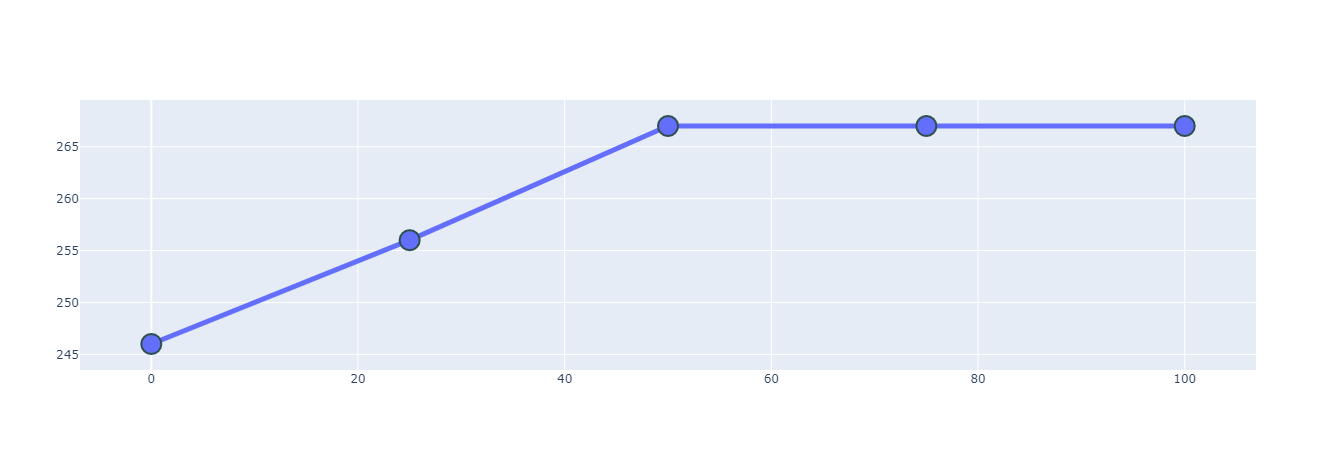

In [174]:
fig.add_trace(
  go.Scatter(
    x= data["missing_data"],
    y = data["all_variants"],
    mode='lines+markers',
    name = "All Variants",
    marker=dict(
      #color='LightSkyBlue',
      size=20,
      line=dict(
        color='DarkSlateGrey',
        width=2,
      )
    ),
    line=dict(width=5),
  )
)

### Add Data - Parsimony Informative Variants

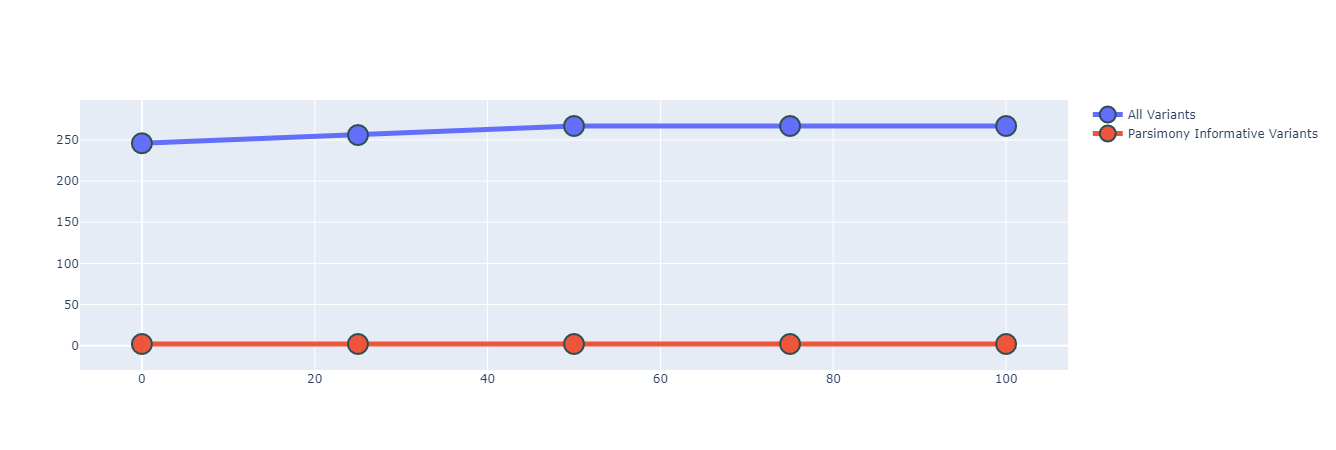

In [175]:
fig.add_trace(
  go.Scatter(
    x= data["missing_data"],
    y = data["parsimony_variants"],
    mode='lines+markers',
    name = "Parsimony Informative Variants",
    marker=dict(
      #color='LightSkyBlue',
      size=20,
      line=dict(
        color='DarkSlateGrey',
        width=2,
      )
    ),
    line=dict(width=5),
  )
)

### Customize Appearance

In [1]:
fig.update_layout(
  template="simple_white", 
  width=1080,
  height=720,
  title=("<b>Variants Across Missing Data Site Thresholds <br> (Samples: " 
          + str(num_samples) 
          + ", Sites: " 
          + str(num_sites) 
          + ") </b>"),
  title_x = 0.5,
  xaxis = dict(
      title = "Missing Data Threshold Per Site (%)",
      tickvals = plot_thresholds,
      ),
  yaxis_title = "Number of Variant Sites",
)


NameError: name 'fig' is not defined

## Display

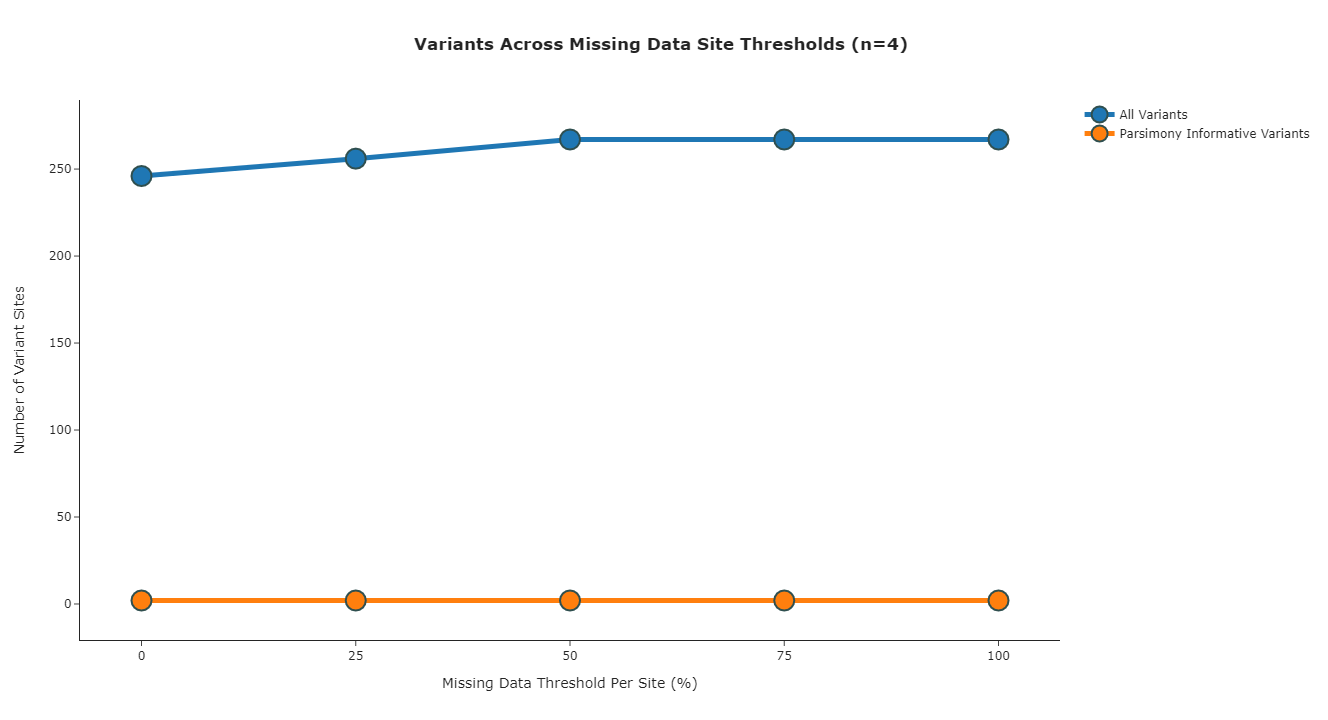

In [190]:
fig.show()

## Save

In [191]:
#output_plot = os.path.join(output_dir, "missing_data.html")
output_plot = snakemake.output.plot
fig.write_html(output_plot)